# Support Vector Machines

In [1]:
from __future__ import division
import numpy as np

To construct the optimal hyperplane that devides two classes, we have to solve

$$
\begin{align}
&\mbox{minimize  } \frac{1}{2} w^T w\\
&\mbox{subject to  } y_i (w^T x_i + b) \ge 1 \mbox{ for all } i = 1,\dots,n
\end{align}
$$

This is a _constrained optimization problem_ and can be solved by introducting Lagrange multiplier $a_i \ge 0$.

$$
L = \frac{1}{2} w^T w + \sum a_i \left( 1 - y_i (w^T w + b) \right)
$$

The Lagrangian $L$ is to be minized w.r.t. $w$ and $b$, and maximized w.r.t. the Lagrange multiplier $a_i \ge 0$.
In other words, a saddle point has to be found. Knowing that the derivatives must vanish leads to

$$
w = \sum a_i y_i x_i, \quad
\sum a_i y_i = 0.
$$

### Soft Margins

## Kernel Functions

In [2]:
def linear_kernel(sigma, **kwargs):
    def f(x, y):
        return 1. + 1. / sigma * np.dot(x, y.T)
    return f


def polynomial_kernel(sigma, degree, **kwargs):
    def f(x, y):
        return (1. + 1. / sigma * np.dot(x, y.T)) ** degree
    return f


def rbf_kernel(sigma, **kwargs):
    def f(x, y):
        m = x.shape[0]
        n = y.shape[0]
        K = (2 * np.dot(x, y.T)
             - np.dot(np.ones((n, 1)), np.atleast_2d(np.sum(x ** 2, axis=1))).T
             - np.dot(np.ones((m, 1)), np.atleast_2d(np.sum(y ** 2, axis=1))))
        return np.exp(K / 2 / sigma ** 2)
    return f

## `cvxopt`

In [3]:
from sklearn import datasets
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import cvxopt
cvxopt.solvers.options['show_progress'] = False

Quadratic programming solver `cvxopt.solvers.qp` takes the inputs `P, q, G, h, A, b` where

$$
\begin{align}
& \mbox{minimize } \frac{1}{2} x^T P x + q^T x \\
& \mbox{subject to } Gx \le h, Ax = b
\end{align}
$$

and $P = y_i y_j K$.

In [4]:
class SVM:

    def __init__(self, kernel='linear', C=None, sigma=1.0, degree=1, thresh=1e-7):
        self.kernel = kernel
        self.C = C
        self.sigma = sigma
        self.degree = degree
        self.thresh = thresh
        
    def _kernel(self):
        if self.kernel == 'linear':
            return linear_kernel
        elif self.kernel == 'poly':
            return polynomial_kernel
        elif self.kernel == 'rbf':
            return rbf_kernel
        else:
            raise ValueError("ERROR:: kernel {} not recognized".format(self.kernel))
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        if y.ndim == 1:
            y = y.reshape((-1, 1))
        
        self.build_kernel = self._kernel()
        self.build_kernel = self.build_kernel(sigma=self.sigma, degree=self.degree)
        K = self.build_kernel(X, X)
        
        P = cvxopt.matrix(y * y.T * K, tc='d')
        q = cvxopt.matrix(-np.ones(n_samples))
        
        if self.C is None:
            G = cvxopt.matrix(-np.eye(n_samples))
            h = cvxopt.matrix(np.zeros((n_samples, 1)))
        else:
            G = cvxopt.matrix(np.vstack((np.eye(n_samples), -np.eye(n_samples))))
            h = cvxopt.matrix(np.vstack((self.C * np.ones((n_samples, 1)), np.zeros((n_samples, 1)))))
        
        A = cvxopt.matrix(y.reshape((1, n_samples)), tc='d')
        b = cvxopt.matrix(0, tc='d')
        
        # Solve QP problem
        sol = cvxopt.solvers.qp(P, q, G, h, A, b)
        
        a = np.array(sol['x'])  # Langrange multipliers
        self.support = np.where(a > self.thresh)[0]  # non-zero Lagrange multipliers
        self.support_vectors = X[self.support]  # support vectors
        self.n_support = self.support_vectors.shape[0]
        self.dual_coef = a[self.support] * y[self.support]  # corresponding targets
        
        self.intercept = np.sum(y[self.support])
        # loop over support vectors
        for i in range(self.n_support):
            self.intercept -= np.sum(self.dual_coef * K[self.support[i], self.support].reshape(self.n_support, 1))
        self.intercept /= self.n_support
        
        print("DEBUG:: Number of support vectors: {}".format(self.n_support))
        print("DEBUG:: Intercept: {}".format(self.intercept))
        
    def predict(self, X, soft=False):
        y_pred = np.empty(len(X))
        K = self.build_kernel(X, self.support_vectors)
        
        for j in range(len(X)):
            prediction = 0
            for i in range(self.n_support):
                prediction += self.dual_coef[i] * K[j, i]
            prediction += self.intercept
            y_pred[j] = prediction if soft else np.sign(prediction)
            
        return y_pred

## Example: Iris Dataset

In [5]:
iris = datasets.load_iris()
X = iris.data[:, [1, 3]]
y = iris.target
# X = normalize(X[y != 0])
X = X[y != 0]
y = y[y != 0]

# make target values -1, 1
y[y == 1] = -1
y[y == 2] = 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [6]:
clf = SVM(kernel='rbf', C=1.0, thresh=1e-5, degree=4)
clf.fit(X_train, y_train)

DEBUG:: Number of support vectors: 32
DEBUG:: Intercept: 0.246485859779


In [7]:
y_pred = clf.predict(X_test)

In [8]:
def accuracy_score(y_true, y_pred):
    return (y_true == y_pred).sum() / len(y_pred)

In [9]:
score = accuracy_score(y_test, y_pred)
print("Accuracy: {}".format(score))

Accuracy: 0.969696969697


## Visualizing the result

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [11]:
def make_meshgrid(x, y, h=0.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

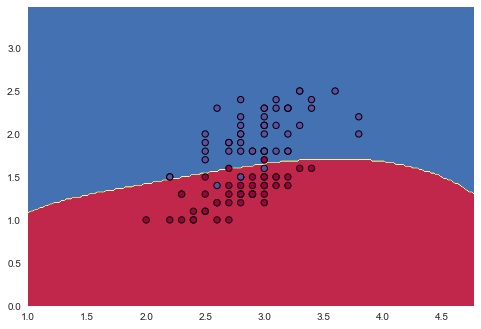

In [12]:
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)
#
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
#
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
plt.scatter(X0, X1, c=y, cmap=plt.cm.Spectral, s=40, edgecolor='k', linewidth=1)

## Using Scikit-learn

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR

In [14]:
clf2 = SVC(kernel='rbf', C=1.0, gamma=1.0, random_state=0)
clf2.fit(X_train, y_train)
y_pred2 = clf2.predict(X_test)

In [15]:
score = accuracy_score(y_test, y_pred2)
print("Accuracy: {}".format(score))
# 
scores = cross_val_score(clf2, X, y, cv=20, scoring='accuracy')
print("Accuracy: {}".format(np.mean(scores)))

Accuracy: 1.0
Accuracy: 0.941666666667


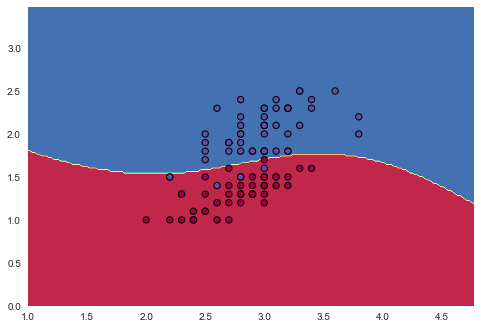

In [16]:
Z2 = clf2.predict(np.c_[xx.ravel(), yy.ravel()])
Z2 = Z2.reshape(xx.shape)
plt.contourf(xx, yy, Z2, cmap=plt.cm.Spectral)
plt.scatter(X0, X1, c=y, cmap=plt.cm.Spectral, s=40, edgecolor='k', linewidth=1)